In [ ]:
# Korean Encoding
!pip install koreanize-matplotlib

In [ ]:
!pip install numpy==1.23.5 catboost==1.2

In [ ]:
from easydict import EasyDict
from collections import Counter

import numpy as np
import pandas as pd

import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

In [ ]:
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

In [ ]:
config = EasyDict({
    'data_path': '/content/drive/MyDrive/Dacon/기업성공확률예측해커톤/data',
    'train_path': '/content/drive/MyDrive/Dacon/기업성공확률예측해커톤/data/train.csv',
    'test_path': '/content/drive/MyDrive/Dacon/기업성공확률예측해커톤/data/test.csv',
    'submission_path': '/content/drive/MyDrive/Dacon/기업성공확률예측해커톤/data/sample_submission.csv'
})

In [ ]:
df_train = pd.read_csv(config.train_path)
df_test = pd.read_csv(config.test_path)
df_submission = pd.read_csv(config.submission_path)

print(df_train.shape)
print(df_test.shape)
print(df_submission.shape)

(4376, 14)
(1755, 13)
(1755, 2)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              4376 non-null   object 
 1   설립연도            4376 non-null   int64  
 2   국가              4376 non-null   object 
 3   분야              3519 non-null   object 
 4   투자단계            4376 non-null   object 
 5   직원 수            4202 non-null   float64
 6   인수여부            4376 non-null   object 
 7   상장여부            4376 non-null   object 
 8   고객수(백만명)        3056 non-null   float64
 9   총 투자금(억원)       4376 non-null   float64
 10  연매출(억원)         4376 non-null   float64
 11  SNS 팔로워 수(백만명)  4376 non-null   float64
 12  기업가치(백억원)       3156 non-null   object 
 13  성공확률            4376 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 478.8+ KB


In [ ]:
TARGET = '성공확률'
cat_features, num_features = [], []
for f in df_train.columns:
    if f == 'ID' or f == TARGET:
        continue
    if df_train[f].dtype == 'object':
        cat_features.append(f)
    else:
        num_features.append(f)

print('Categorical Features:')
print(cat_features)
print('Numerical Features:')
print(num_features)

Categorical Features:
['국가', '분야', '투자단계', '인수여부', '상장여부', '기업가치(백억원)']
Numerical Features:
['설립연도', '직원 수', '고객수(백만명)', '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)']


In [ ]:
df_train[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
설립연도,4376.0,2012.006856,6.554872,2001.0,2006.00,2012.000,2018.00,2023.0
직원 수,4202.0,2471.324369,1446.064215,5.0,1218.25,2472.000,3727.50,4998.0
고객수(백만명),3056.0,49.214332,27.141242,1.0,27.00,49.000,72.00,99.0
총 투자금(억원),4376.0,3314.568556,1880.103831,12.0,1651.50,3398.000,4908.25,7059.0
연매출(억원),4376.0,6452.202239,3782.792656,12.0,3094.25,6478.500,9692.50,14822.0
SNS 팔로워 수(백만명),4376.0,2.578103,1.414590,0.0,1.32,2.835,4.00,5.0


# EDA

In [ ]:
def plot_categorical_features(df, cat_features):
    n = len(cat_features)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 5, n_rows * 4))

    for i, col in enumerate(cat_features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f'{col} (count)')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_categorical_features_by_target(df, cat_features, target):
    n = len(cat_features)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 6, n_rows * 5))  # 그래프 전체 크기 조절

    for i, col in enumerate(cat_features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.countplot(data=df, x=col, hue=target, order=df[col].value_counts().index)
        plt.title(f'{col} by {target}')
        plt.xticks(rotation=45)
        plt.xlabel(col)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_numeric_features(df, num_features):
    n = len(num_features)
    plt.figure(figsize=(12, 4 * n))  # 각 행의 높이는 4

    for i, col in enumerate(num_features):
        # 히스토그램 (왼쪽)
        plt.subplot(n, 2, 2 * i + 1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'{col} - Histogram')

        # 박스플롯 (오른쪽)
        plt.subplot(n, 2, 2 * i + 2)
        sns.boxplot(x=df[col])
        plt.title(f'{col} - Boxplot')

    plt.tight_layout()
    plt.show()

def plot_numeric_by_target(df, num_features, target):
    n = len(num_features)
    plt.figure(figsize=(14, 4 * n))  # 한 feature당 1행(2개 plot)

    for i, col in enumerate(num_features):
        # 히스토그램 (왼쪽): target에 따라 색 다르게
        plt.subplot(n, 2, 2 * i + 1)
        sns.histplot(data=df, x=col, hue=target, kde=True, element='step')
        plt.title(f'{col} - Histogram by {target}')

        # 박스플롯 (오른쪽): target별 박스
        plt.subplot(n, 2, 2 * i + 2)
        sns.boxplot(data=df, x=target, y=col)
        plt.title(f'{col} - Boxplot by {target}')

    plt.tight_layout()
    plt.show()


## 범주형 변수 시각화


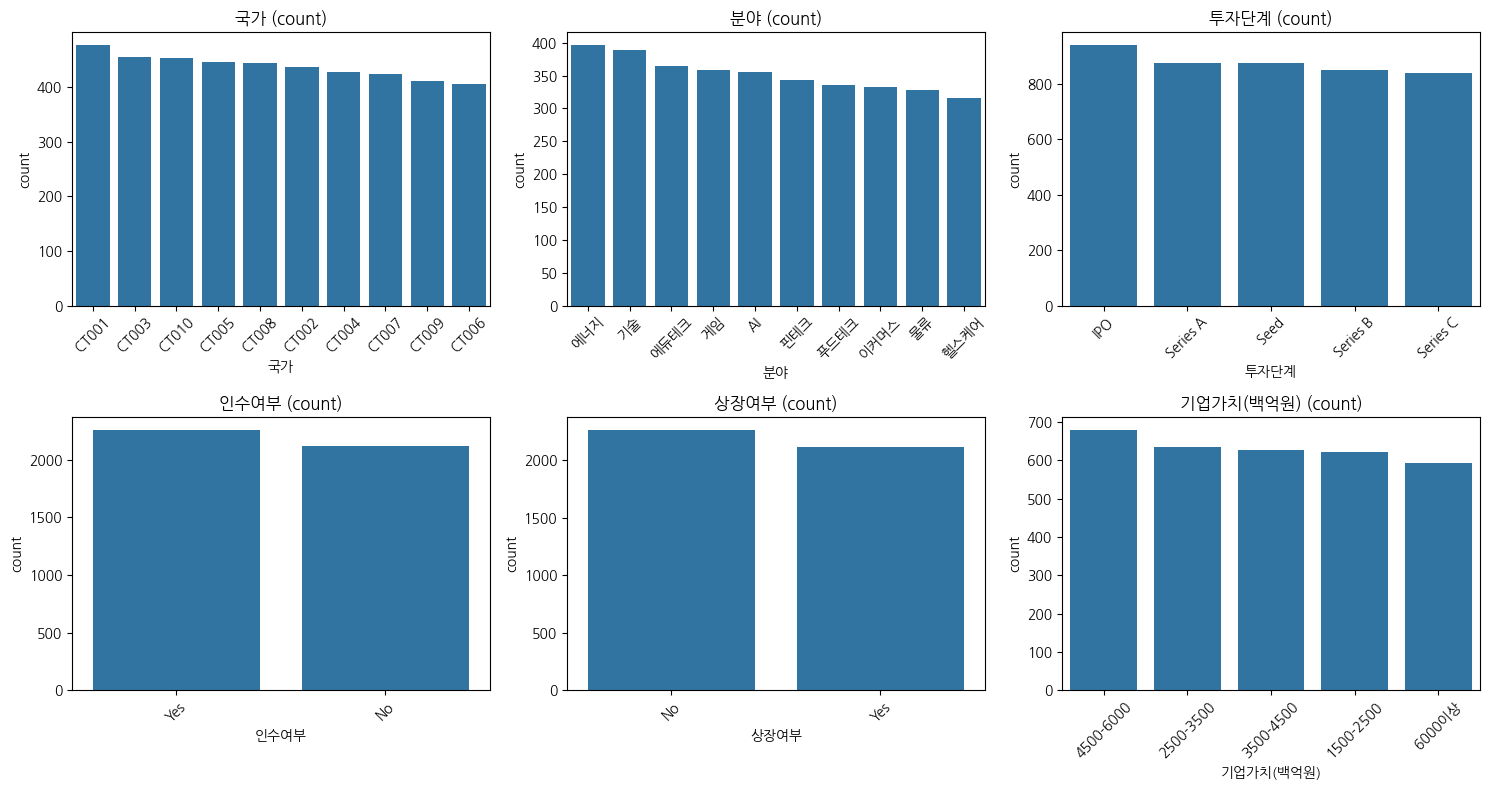

In [ ]:
plot_categorical_features(df_train, cat_features)

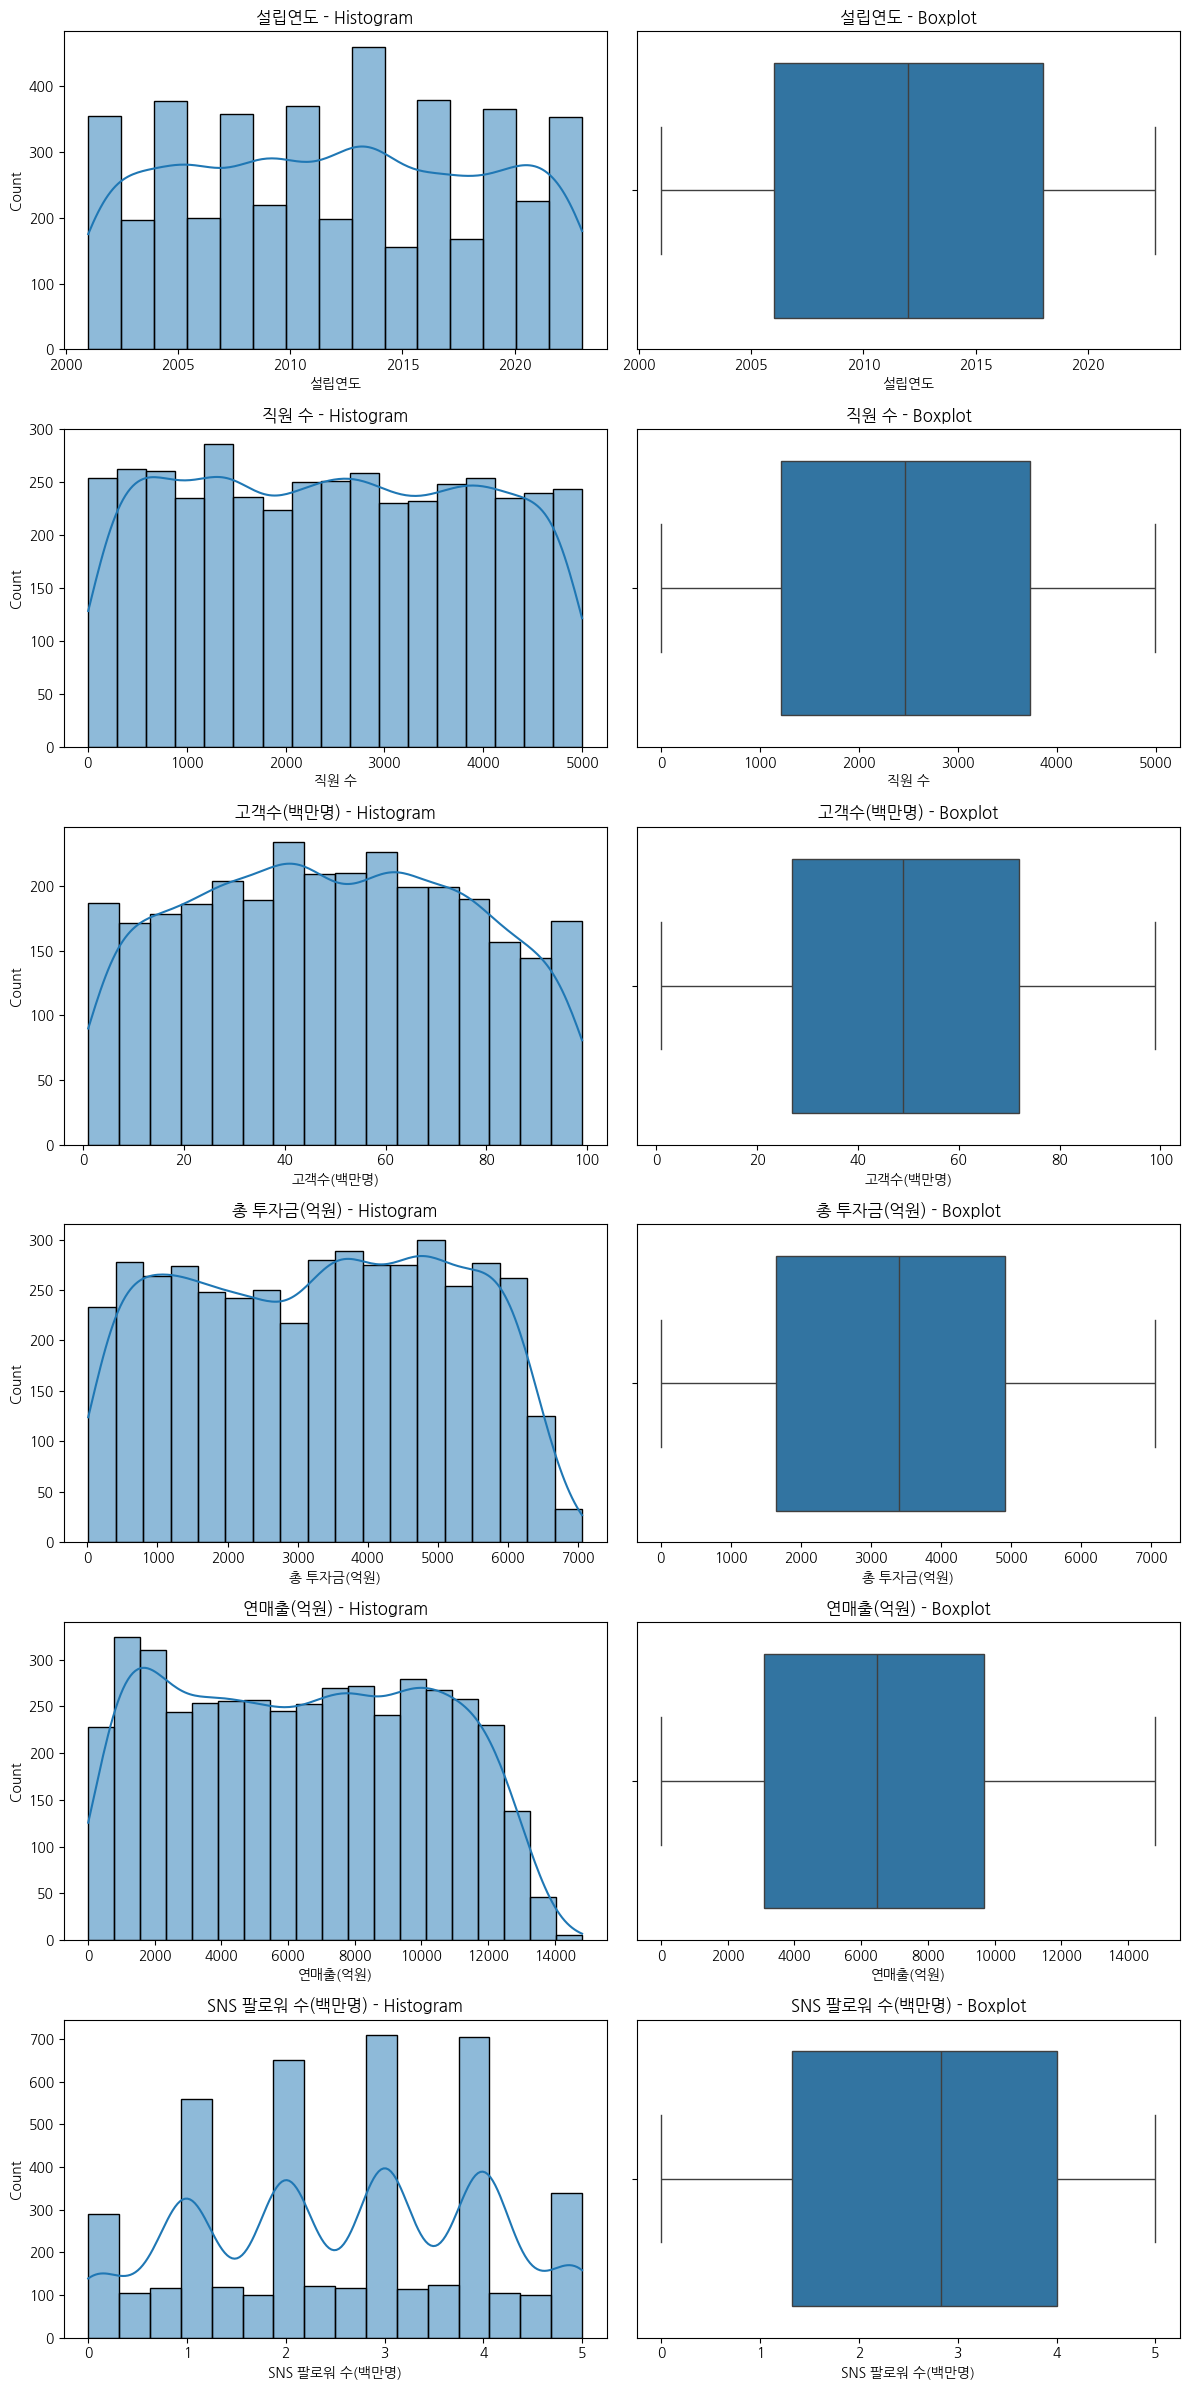

In [ ]:
plot_numeric_features(df_train, num_features)

TARGET이 0 <= '성공확률' <= 1 인 실수이기 때문에, hue를 사용할 수 없음

In [ ]:
def plot_categorical_features_with_target(df, cat_features, target):
    n = len(cat_features)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 6, n_rows * 5))

    for i, col in enumerate(cat_features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df, x=col, y=target, order=df[col].value_counts().index)
        plt.title(f'{col} vs {target}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_numeric_vs_target(df, num_features, target):
    n = len(num_features)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 6, n_rows * 4))

    for i, col in enumerate(num_features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.regplot(data=df, x=col, y=target, scatter_kws={'s': 10}, line_kws={'color': 'red'})
        plt.title(f'{col} vs {target}')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_target_correlations(df, num_features, target_col='target'):
    corr = df[num_features + [target_col]].corr()[[target_col]].drop(target_col)

    plt.figure(figsize=(5, len(corr) * 0.5 + 1))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Correlation with {target_col}')
    plt.show()

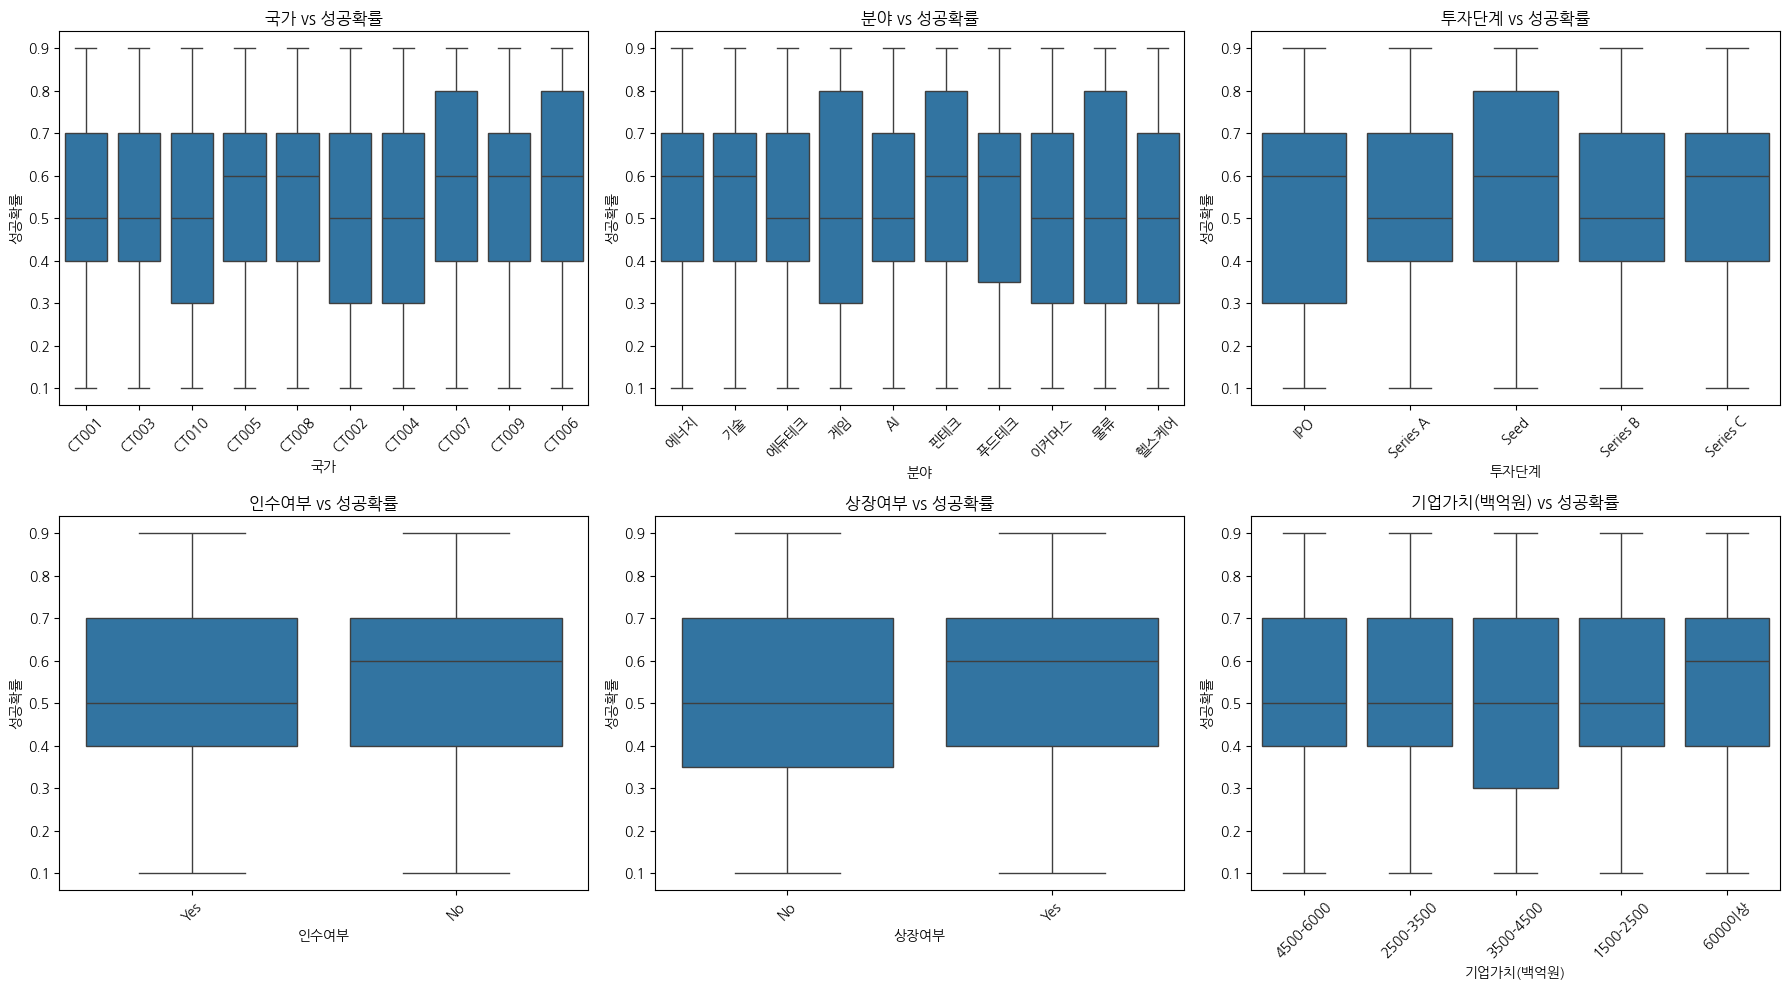

In [ ]:
plot_categorical_features_with_target(df_train, cat_features, TARGET)

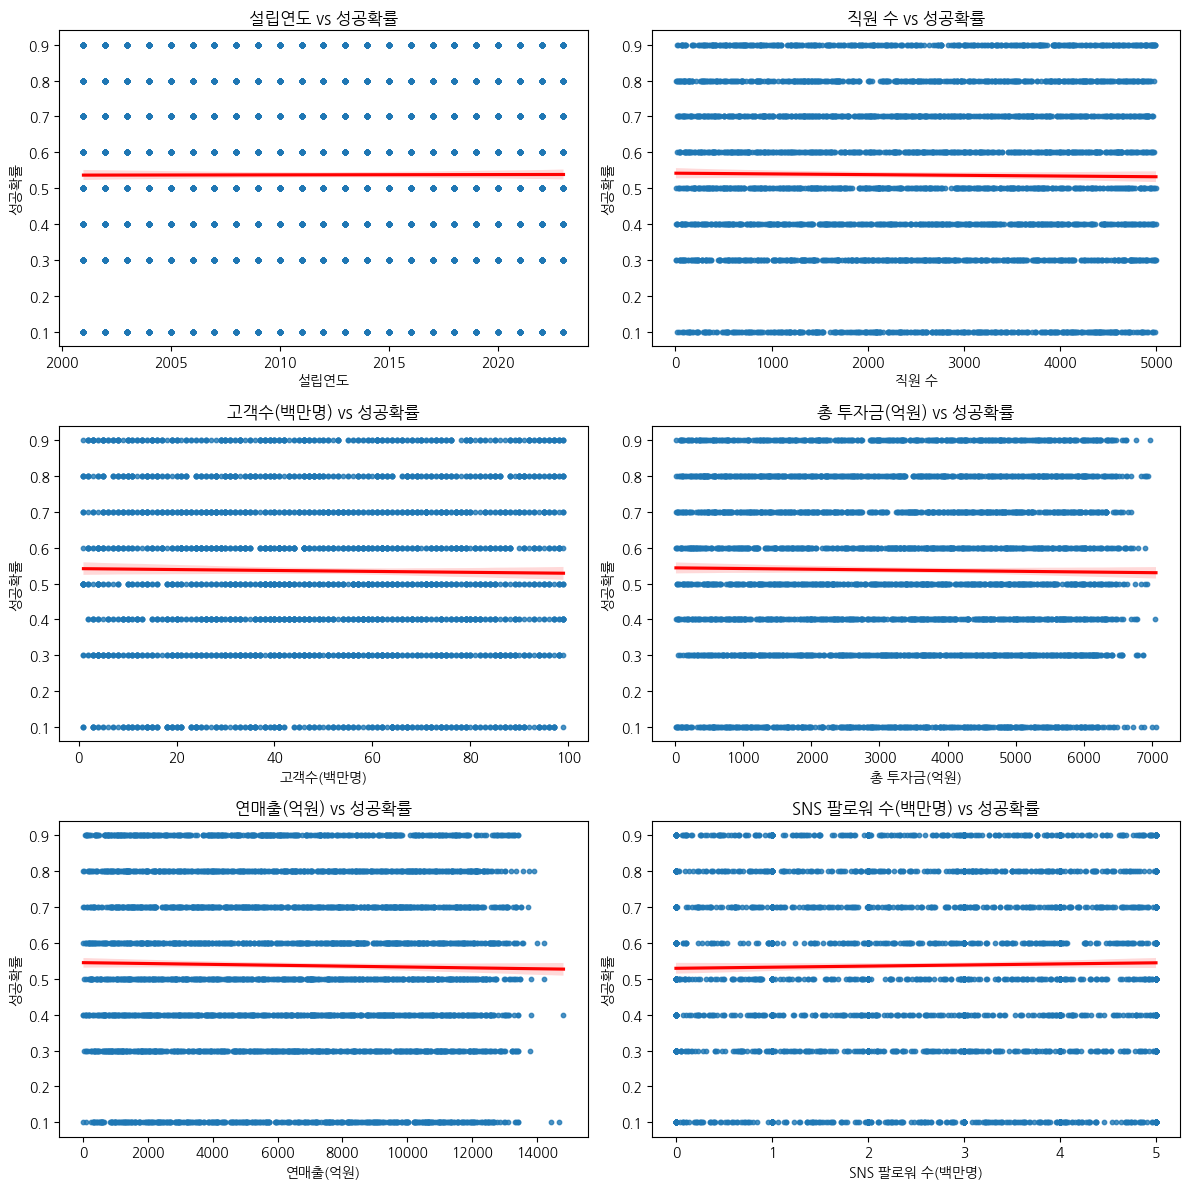

In [ ]:
plot_numeric_vs_target(df_train, num_features, TARGET)

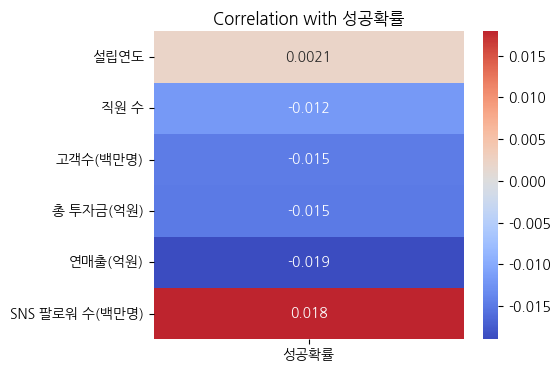

In [ ]:
plot_target_correlations(df_train, num_features, TARGET)

In [ ]:
df_train[num_features + [TARGET]].corr()

,설립연도,직원 수,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),성공확률
설립연도,1.000000,-0.009840,0.007936,0.006222,0.002057,-0.006881,0.002147
직원 수,-0.009840,1.000000,-0.016341,0.031995,0.049059,-0.010408,-0.011831
고객수(백만명),0.007936,-0.016341,1.000000,-0.010609,0.002650,0.021501,-0.014746
총 투자금(억원),0.006222,0.031995,-0.010609,1.000000,0.036128,0.007984,-0.014939
연매출(억원),0.002057,0.049059,0.002650,0.036128,1.000000,-0.008301,-0.018994
SNS 팔로워 수(백만명),-0.006881,-0.010408,0.021501,0.007984,-0.008301,1.000000,0.017927
성공확률,0.002147,-0.011831,-0.014746,-0.014939,-0.018994,0.017927,1.000000


### 상관계수 분석 결과
- TARGET과 변수들의 상관관계가 매우 약함
- 선형회귀와 같은 선형 모델은 적절하지 않음
- 비선형모델을 고려

성공확률을 10%씩 나눠서 시각화 시도

In [ ]:
def plot_cat_dist_by_target_bin(df, cat_features, bin_col='target_bin'):
    n = len(cat_features)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 6, n_rows * 5))

    for i, col in enumerate(cat_features):
        plt.subplot(n_rows, n_cols, i + 1)
        data = df.copy()
        sns.histplot(data=data, x=col, hue=bin_col, multiple='fill', shrink=0.8, stat='probability', discrete=True)
        plt.title(f'{col} by {bin_col} (비율)')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_num_dist_by_target_bin(df, num_features, bin_col='target_bin'):
    n = len(num_features)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 6, n_rows * 5))

    for i, col in enumerate(num_features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df, x=bin_col, y=col)
        plt.title(f'{col} by {bin_col}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

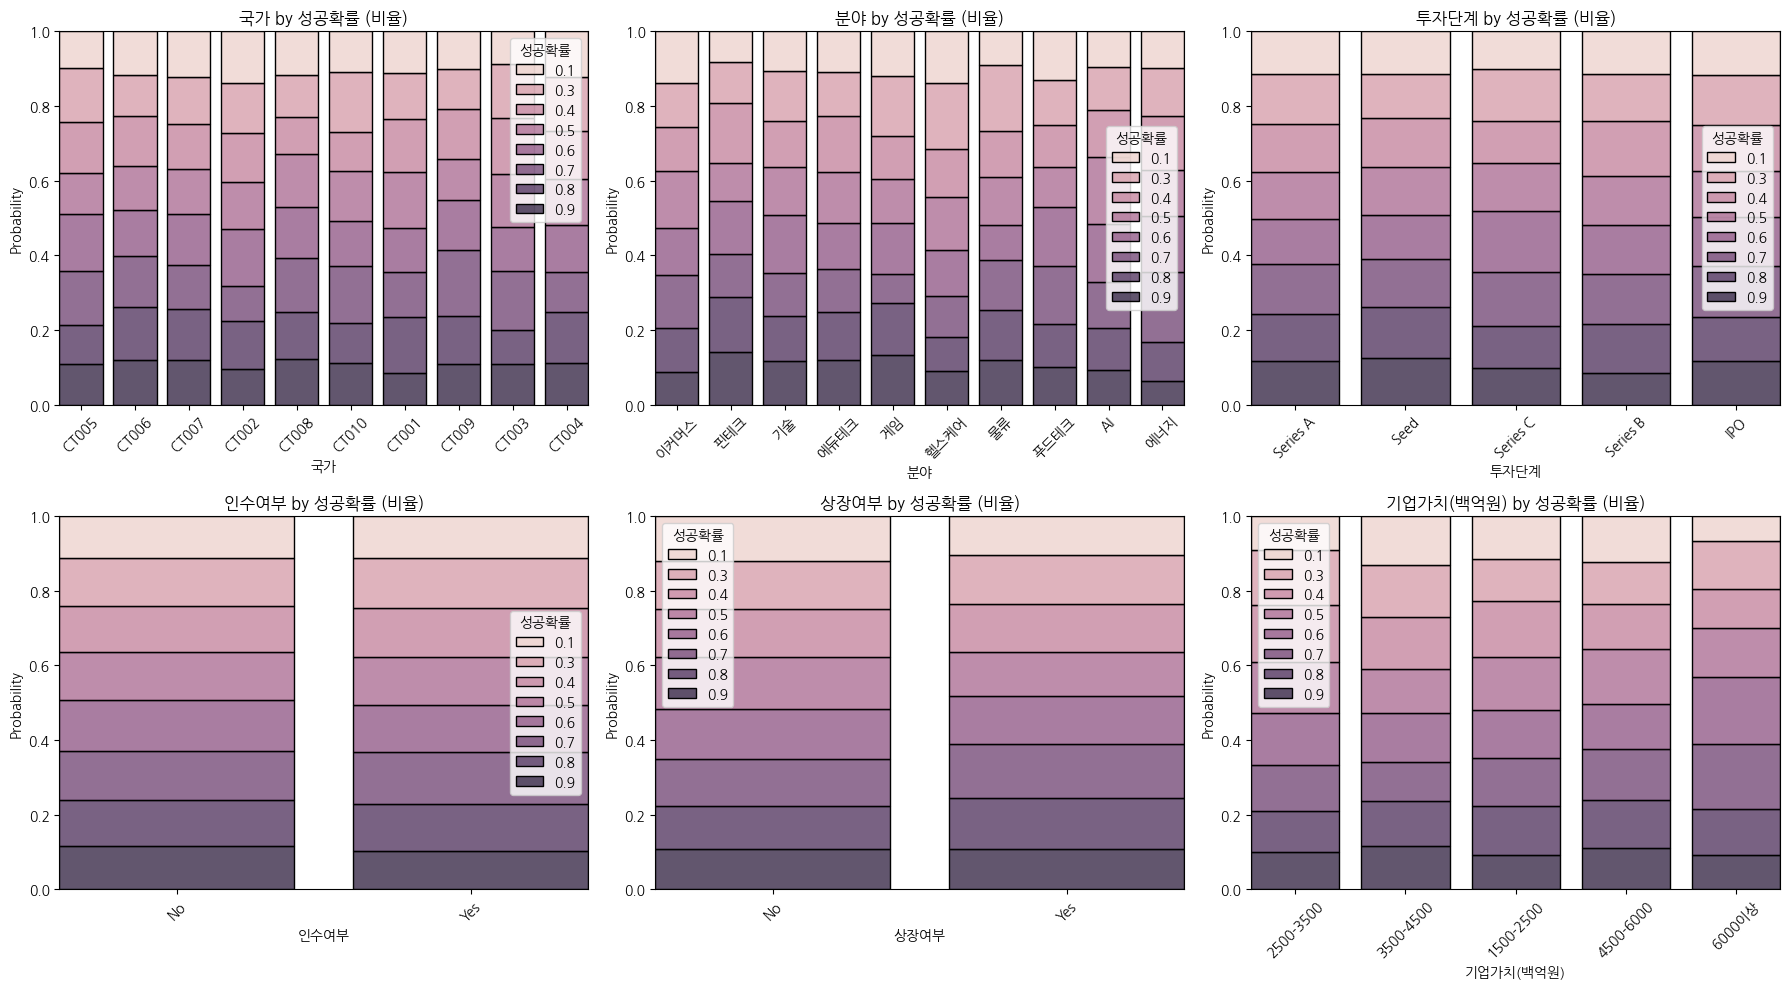

In [ ]:
plot_cat_dist_by_target_bin(df_train, cat_features, TARGET)

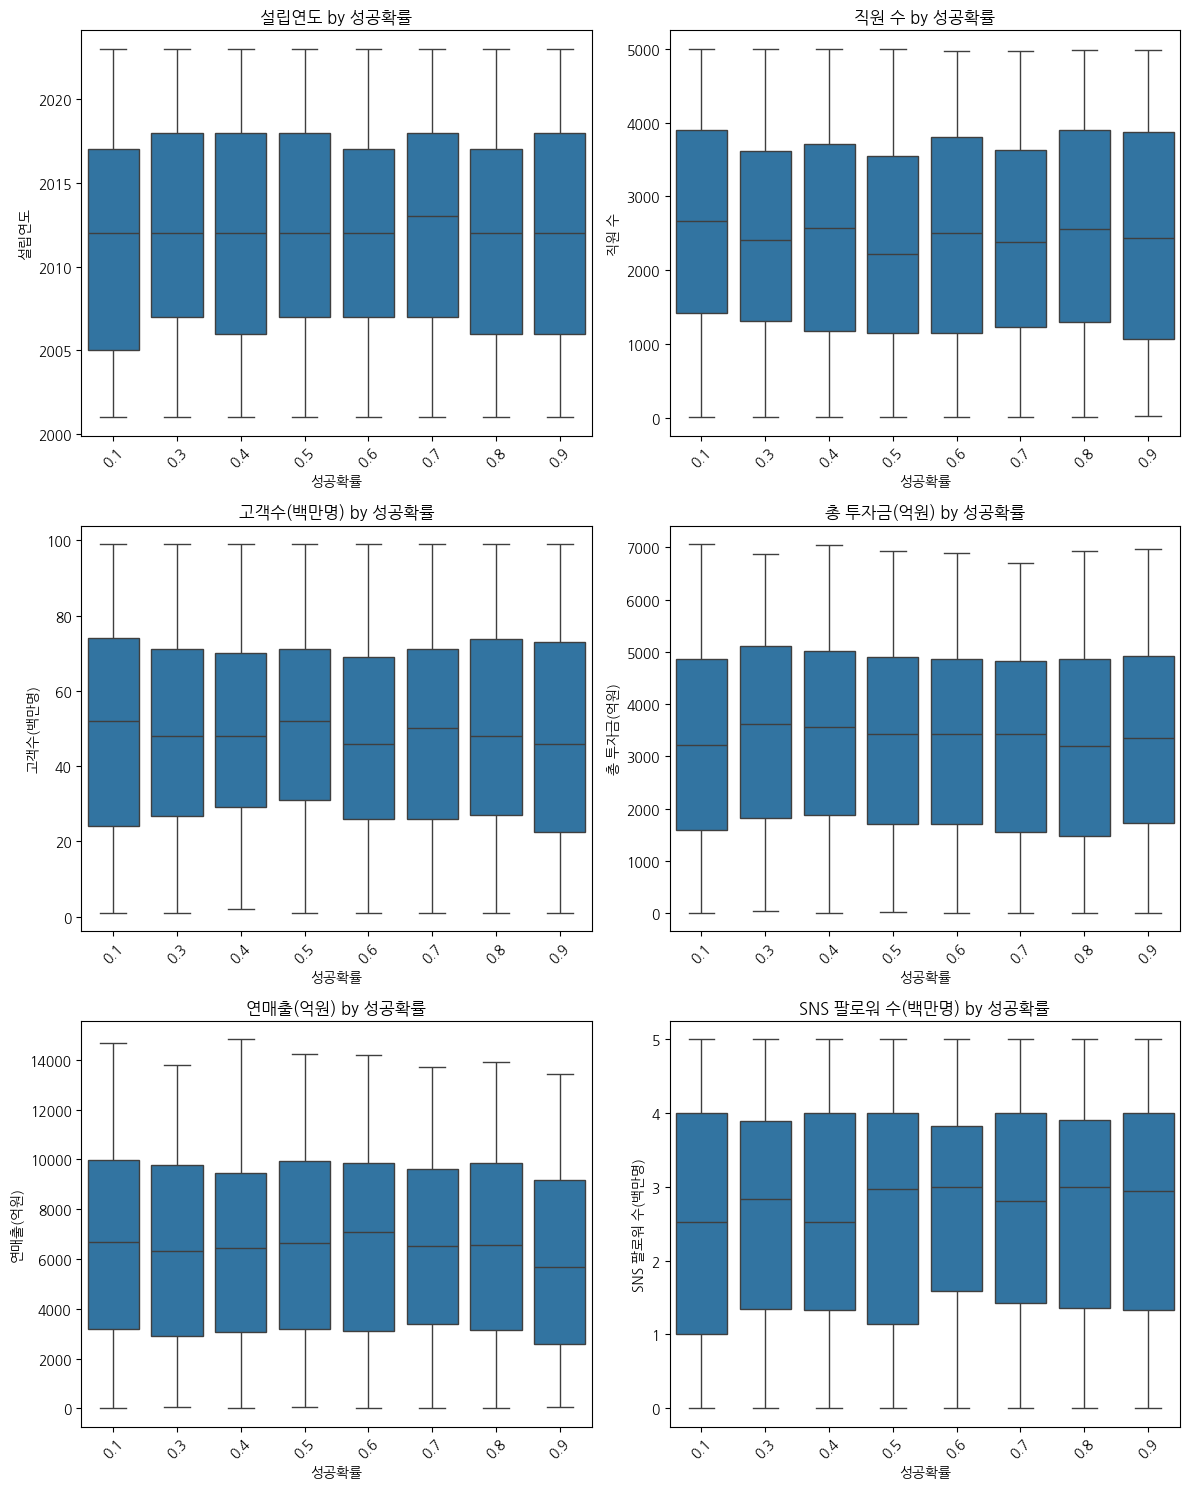

In [ ]:
plot_num_dist_by_target_bin(df_train, num_features, TARGET)

# 결측치 처리

## 결측치 통계량 요약

In [ ]:
missing_summary = df_train.isnull().sum().to_frame(name='missing_count')
missing_summary['missing_ratio'] = (missing_summary['missing_count'] / len(df_train)).round(3)
missing_summary = missing_summary[missing_summary['missing_count'] > 0]
missing_summary

,missing_count,missing_ratio
분야,857,0.196
직원 수,174,0.040
고객수(백만명),1320,0.302
기업가치(백억원),1220,0.279


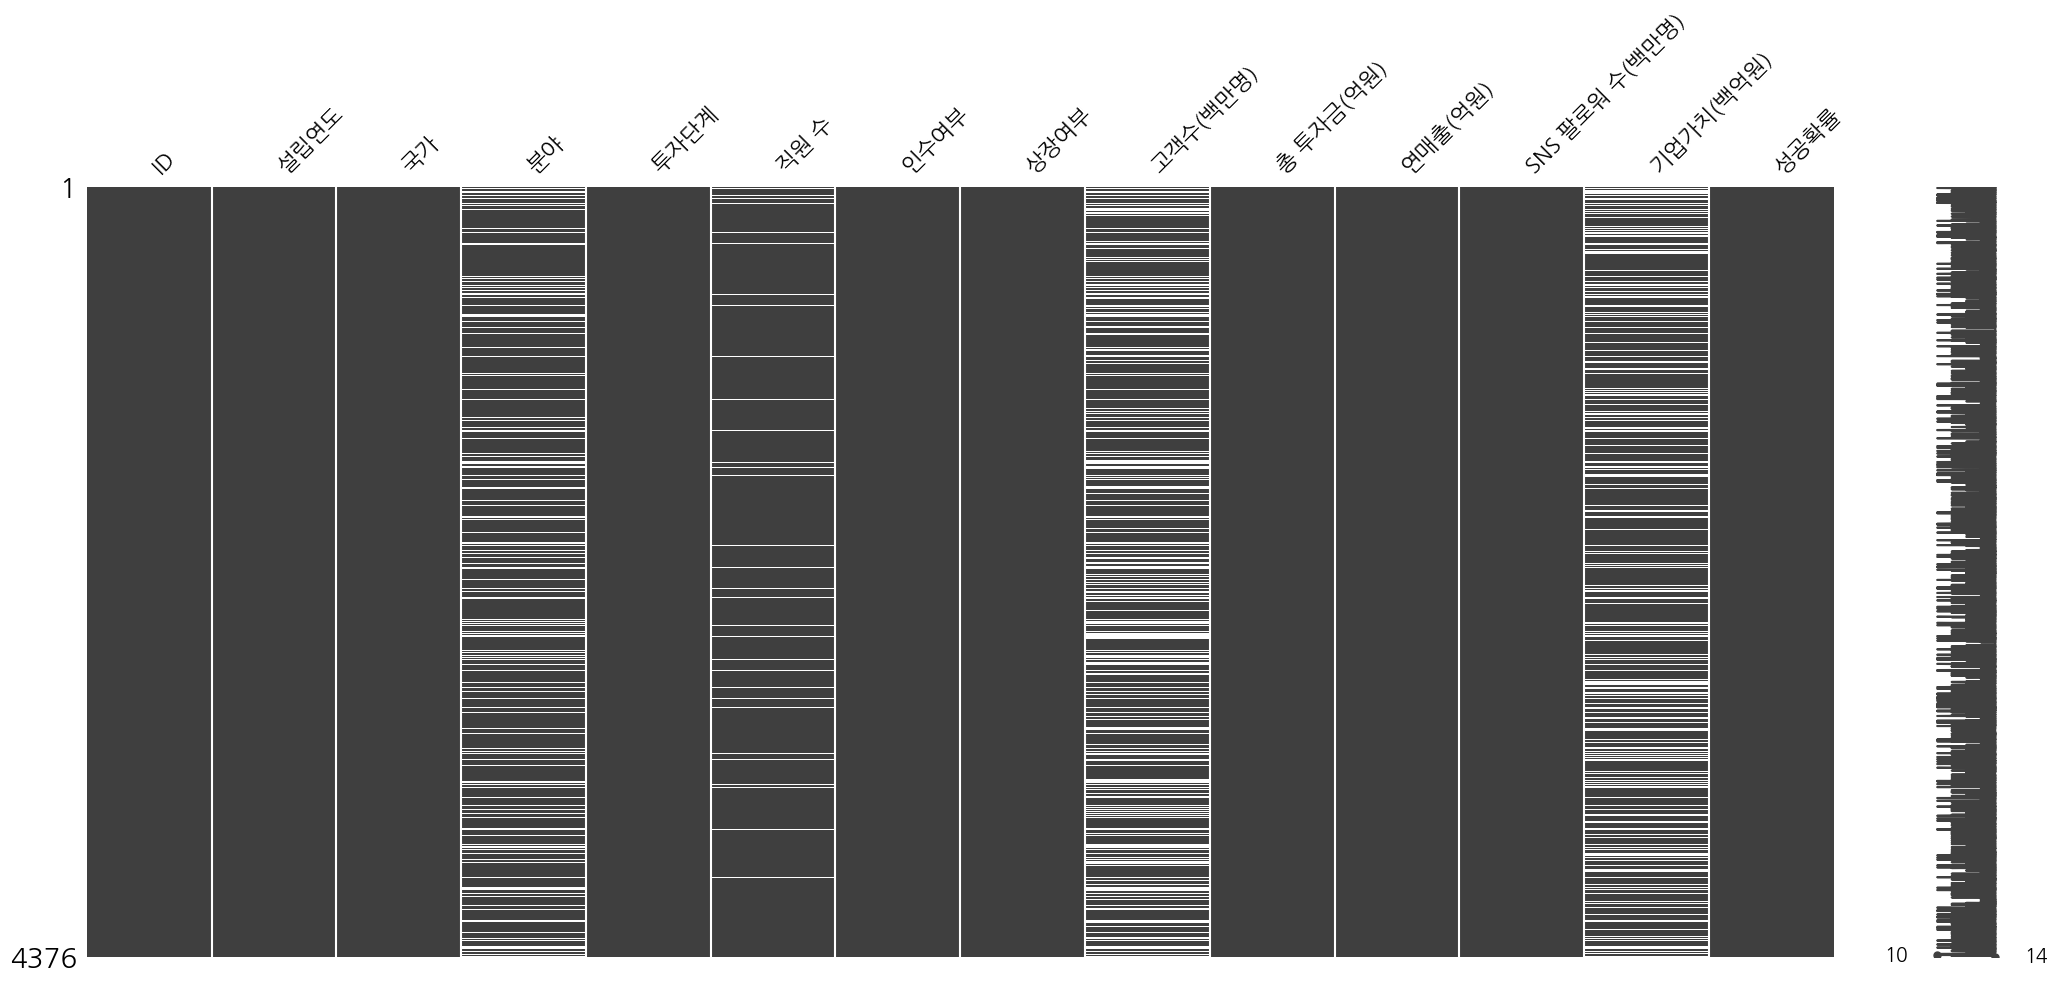

In [ ]:
# 결측치 히트맵
msno.matrix(df_train)
plt.show()

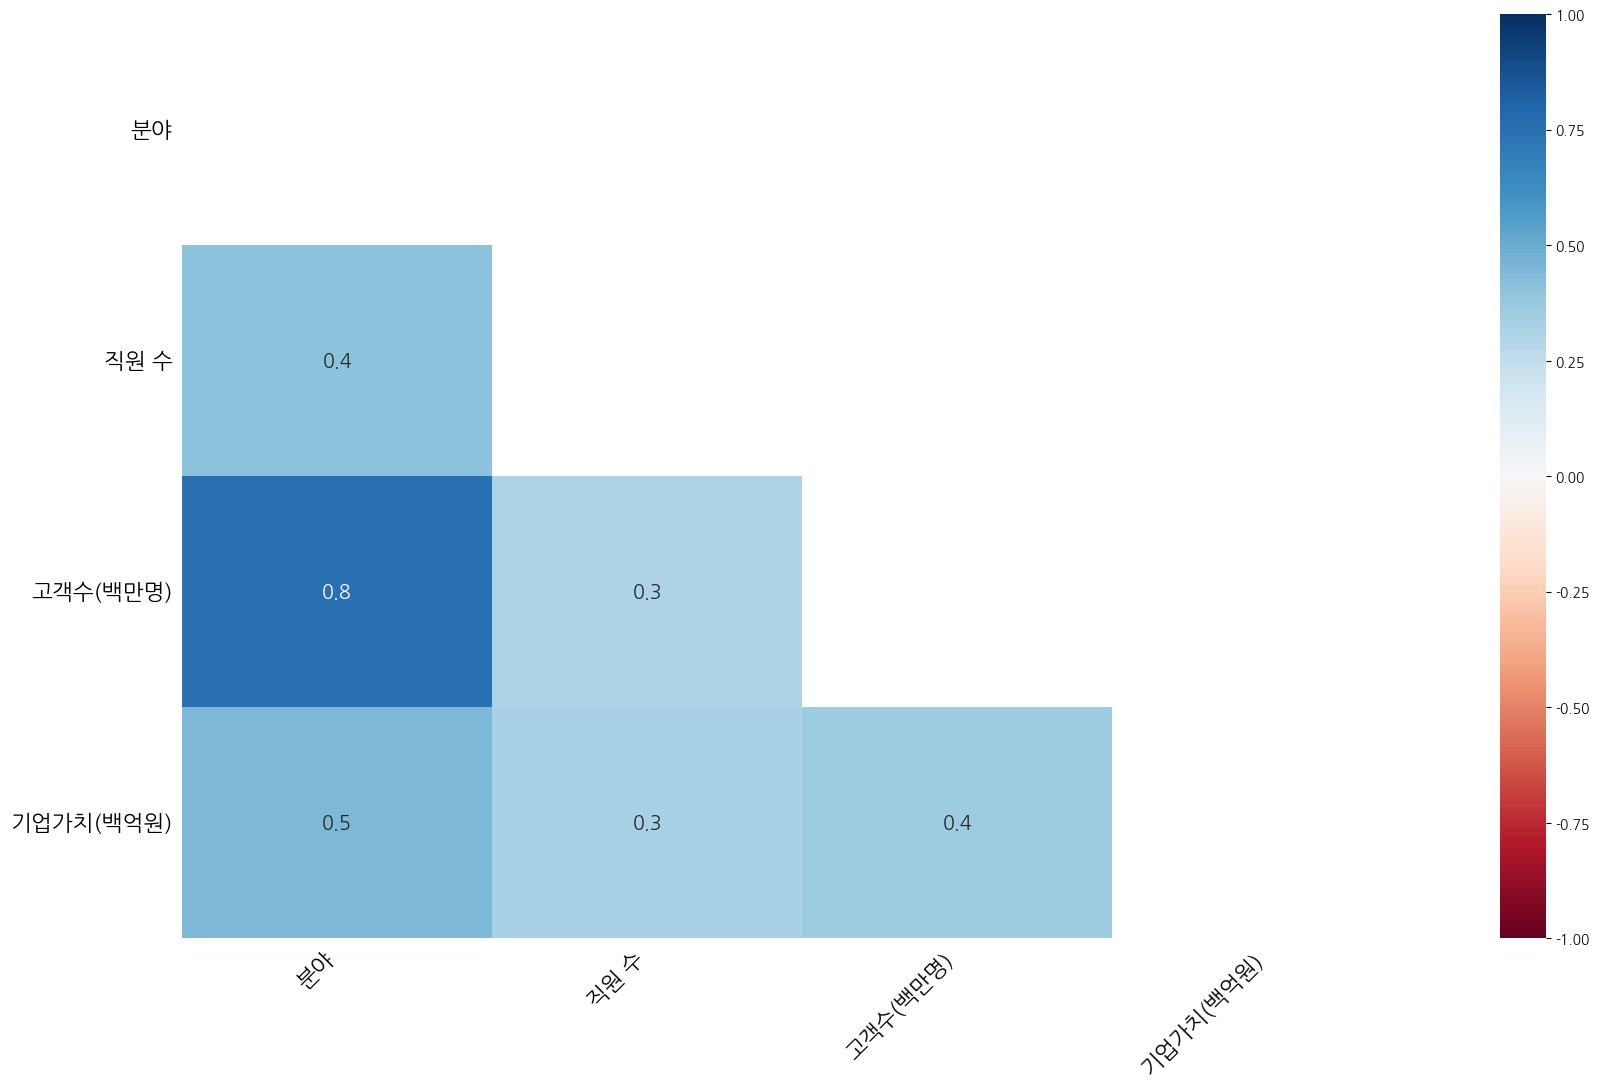

In [ ]:
# 결측치 간 상관관계 (결측 패턴 간 관계)
msno.heatmap(df_train)
plt.show()

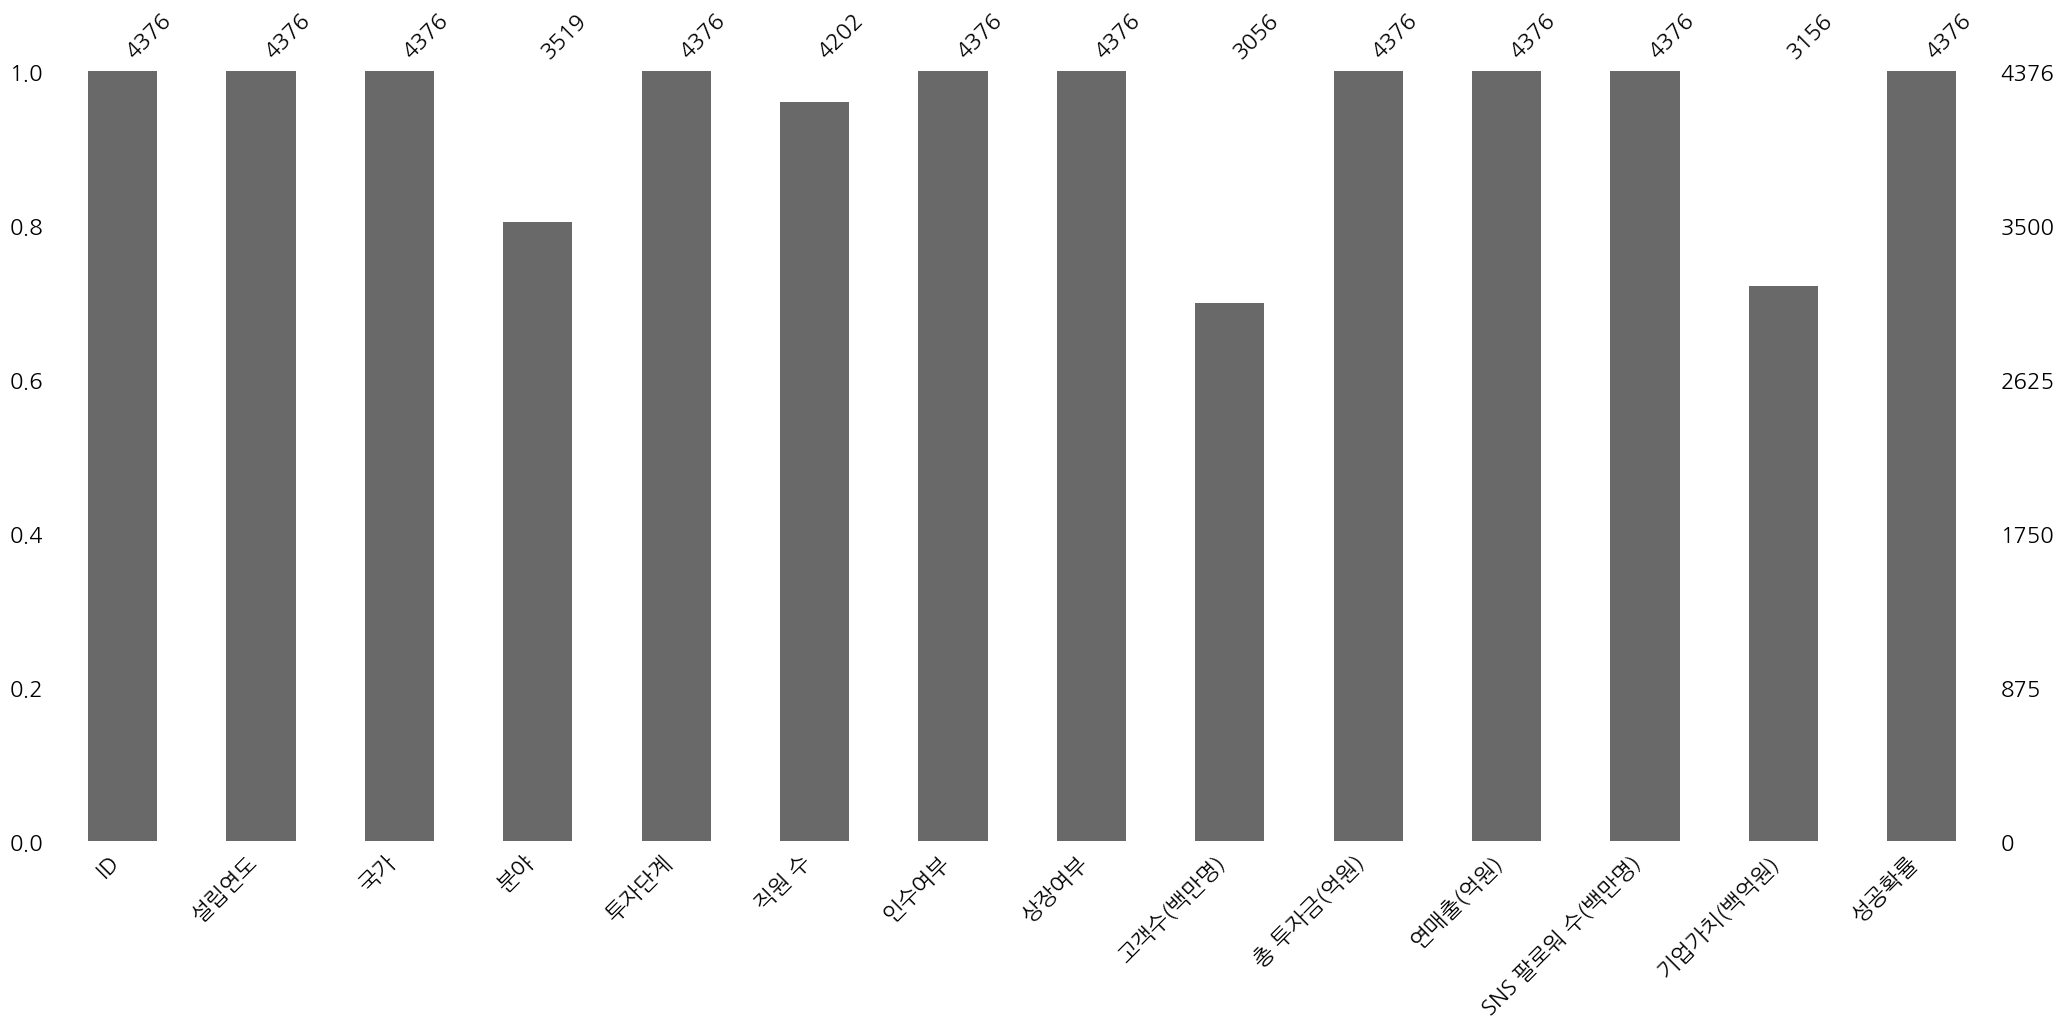

In [ ]:
# 결측치가 있는 컬럼들의 조합을 막대그래프로
msno.bar(df_train)
plt.show()

# 결측치 분석
- 고객수, 기업가치의 결측치는 꽤 높은 편 (30%, 28%)
- 분야 역시 적지 않음 (약 20%)

# 결측치 상관관계 분석
- (분야, 고객수)는 0.8로 매우 강한 상관관계 있음
- (분야, 기업가치), (분야, 직원수), (고객수, 기업가치) 꽤 높음 (0.4)
- 분야가 결측인 경우, 다른 변수들도 함께 결측일 수 있음

In [ ]:
df_train['분야_null'] = df_train['분야'].isnull()
df_train['고객수_null'] = df_train['고객수(백만명)'].isnull()
df_train['기업가치_null'] = df_train['기업가치(백억원)'].isnull()
df_train['직원수_null'] = df_train['직원 수'].isnull()

df_test['분야_null'] = df_test['분야'].isnull()
df_test['고객수_null'] = df_test['고객수(백만명)'].isnull()
df_test['기업가치_null'] = df_test['기업가치(백억원)'].isnull()
df_test['직원수_null'] = df_test['직원 수'].isnull()

In [ ]:
def compare_numeric_by_missing(df, null_col, num_cols):
    n = len(num_cols)
    n_cols = 2
    n_rows = (n + 1) // n_cols

    plt.figure(figsize=(n_cols * 6, n_rows * 4))

    for i, col in enumerate(num_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df, x=null_col, y=col)
        plt.title(f"{col} by {null_col}")
        plt.xticks([0, 1], ['Not Missing', 'Missing'])

    plt.tight_layout()
    plt.show()

In [ ]:
def compare_categorical_by_missing(df, null_col, cat_cols):
    n = len(cat_cols)
    n_cols = 2
    n_rows = (n + 1) // n_cols

    plt.figure(figsize=(n_cols * 6, n_rows * 4))

    for i, col in enumerate(cat_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.countplot(data=df, x=col, hue=null_col)
        plt.title(f"{col} by {null_col}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

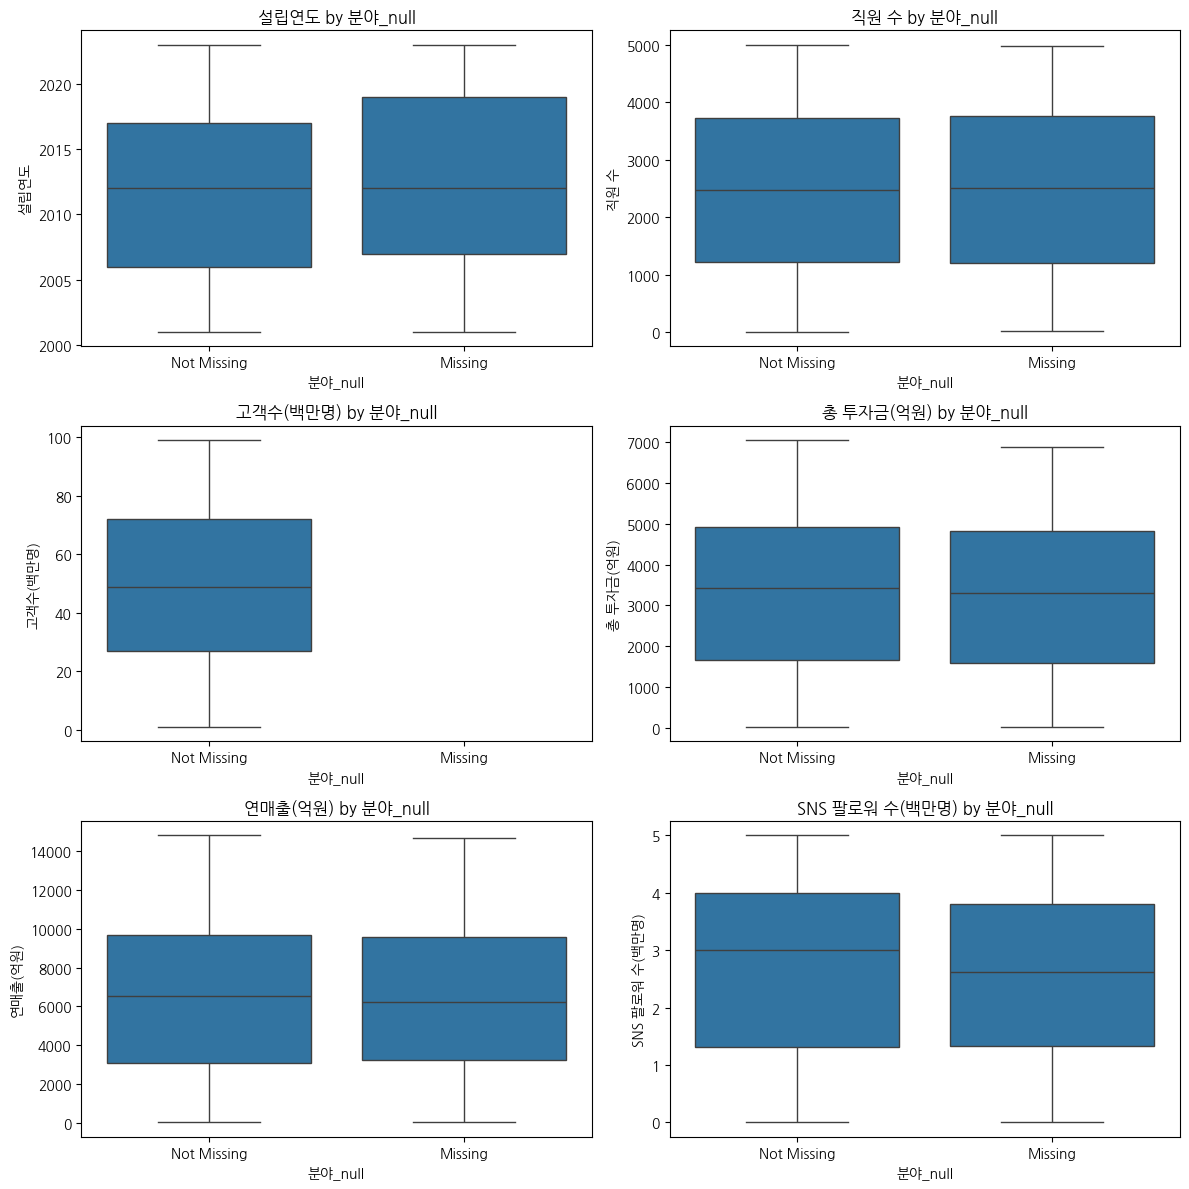

In [ ]:
compare_numeric_by_missing(df_train, '분야_null', num_features)

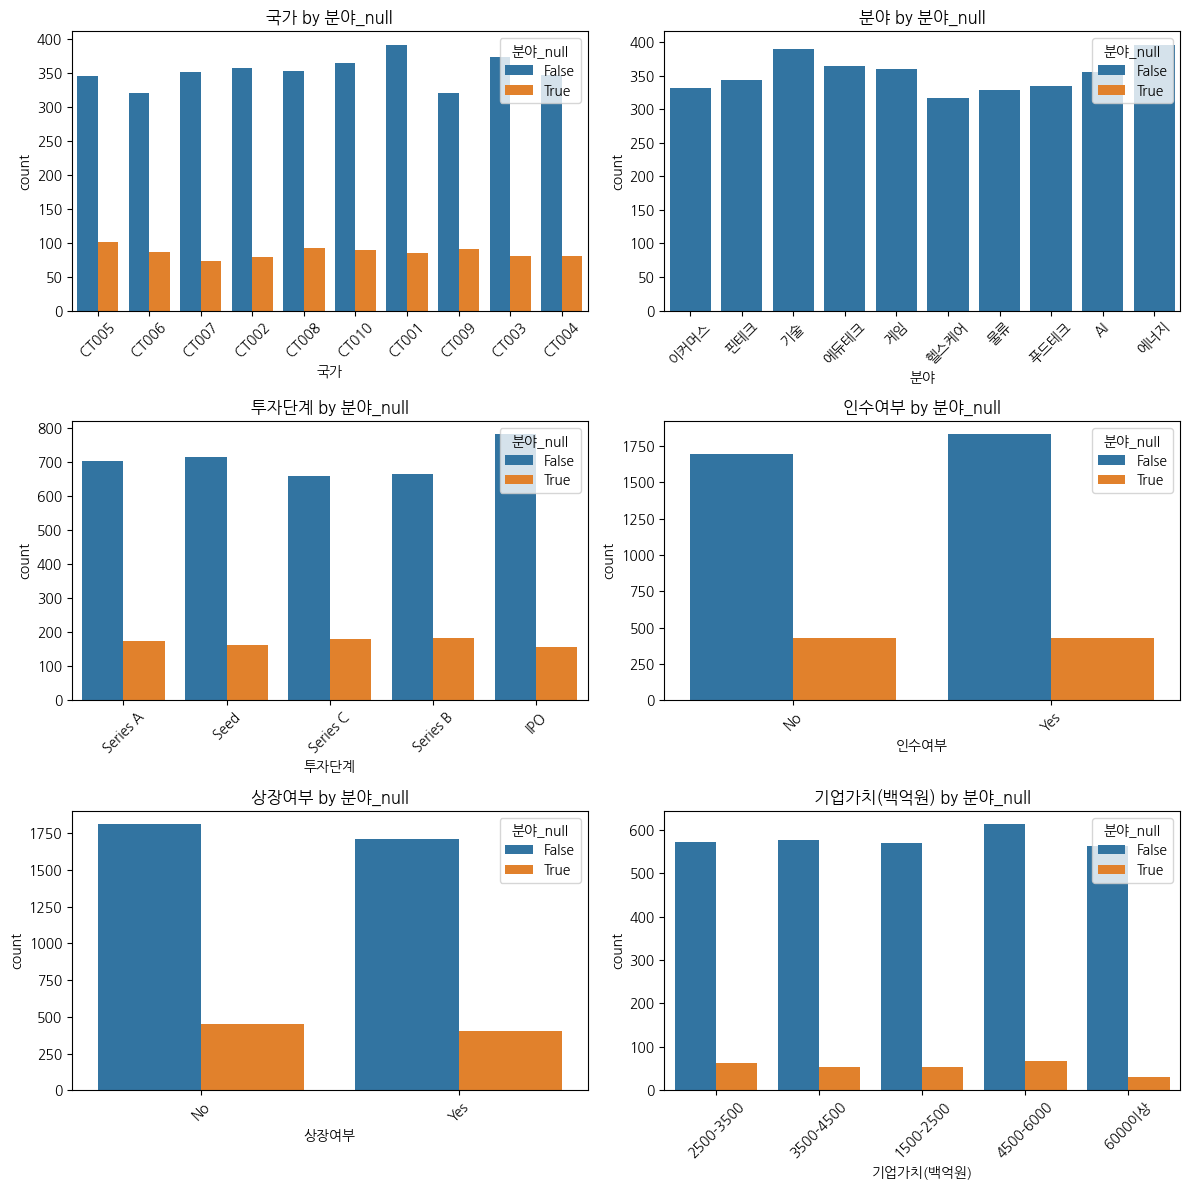

In [ ]:
compare_categorical_by_missing(df_train, '분야_null', cat_features)

# 결측치 상관관계 분석2
- 분야는 고객수와 매우 강한 분포 차이가 있음
- 특정 분야에서 의도적으로 결측치가 존재하는가? (MNAR)
- 다른 수치형, 범주형 변수에서는 이렇다 할 차이가 없음
- `분야_null`이라는 변수 자체를 이용할 수 있음
- `IterativeImputer()` 이용하여 결측치를 채우겠음

In [ ]:
# --- Step 1. 수치형 변수 결측치 처리 (IterativeImputer) ---

df_train_filled = df_train.copy()
df_test_filled = df_test.copy()

features_for_imputation = num_features.copy()

iter_imputer = IterativeImputer(max_iter=10, random_state=42)
df_train_filled[features_for_imputation] = iter_imputer.fit_transform(df_train_filled[features_for_imputation])
df_test_filled[features_for_imputation] = iter_imputer.transform(df_test_filled[features_for_imputation])

# --- Step 2. 범주형 변수 결측치 처리 (KNNImputer + LabelEncoding) ---

cat_missing_cols = ['분야', '기업가치(백억원)']

# 1. train 처리
encoders = {}
X_cat_train = df_train_filled[cat_missing_cols].copy()

for col in cat_missing_cols:
    le = LabelEncoder()

    # 문자열 'nan', '', 'None'을 진짜 np.nan으로 바꿈 (순서 중요)
    X_cat_train[col] = X_cat_train[col].replace(['nan', '', 'None'], np.nan)

    # 결측이 아닌 값만으로 LabelEncoder 학습
    le.fit(X_cat_train[col].dropna())

    # 결측 아닌 값만 transform
    X_cat_train[col] = X_cat_train[col].map(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)
    encoders[col] = le

# KNN Imputer로 결측 채우기
knn_imputer = KNNImputer(n_neighbors=5)
X_cat_train_imputed = knn_imputer.fit_transform(X_cat_train)

# 역변환
X_cat_train_filled = pd.DataFrame(X_cat_train_imputed, columns=cat_missing_cols)
for col in cat_missing_cols:
    le = encoders[col]
    X_cat_train_filled[col] = le.inverse_transform(X_cat_train_filled[col].round().astype(int))

# 결과 반영
df_train_filled[cat_missing_cols] = X_cat_train_filled

# 2. test 처리
X_cat_test = df_test_filled[cat_missing_cols].copy()

for col in cat_missing_cols:
    le = encoders[col]

    # 문자열 'nan', '', 'None'을 np.nan으로
    X_cat_test[col] = X_cat_test[col].replace(['nan', '', 'None'], np.nan)

    # train 기준으로 transform
    known_classes = set(le.classes_)
    X_cat_test[col] = X_cat_test[col].map(lambda x: le.transform([x])[0] if pd.notna(x) and x in known_classes else np.nan)

X_cat_test_imputed = knn_imputer.transform(X_cat_test)

X_cat_test_filled = pd.DataFrame(X_cat_test_imputed, columns=cat_missing_cols)
for col in cat_missing_cols:
    le = encoders[col]
    X_cat_test_filled[col] = le.inverse_transform(X_cat_test_filled[col].round().astype(int))

df_test_filled[cat_missing_cols] = X_cat_test_filled


In [ ]:
print(df_train_filled.columns)
print(df_test_filled.columns)

Index(['ID', '설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부', '고객수(백만명)',
       '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '성공확률',
       '분야_null', '고객수_null', '기업가치_null', '직원수_null'],
      dtype='object')
Index(['ID', '설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부', '고객수(백만명)',
       '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '분야_null',
       '고객수_null', '기업가치_null', '직원수_null'],
      dtype='object')


In [ ]:
def weighted_mae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [ ]:
# 2. X, y 분리
X = df_train_filled.copy().drop(columns=['ID', TARGET])
y = df_train_filled[TARGET]

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wmae_scores = []
models = []

for train_idx, val_idx in kf.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    counts = Counter(y_tr.round(2))  # 예: 0.01 단위 binning
    val_weights = np.array([1 / counts.get(round(y, 2), 1) for y in y_val])

    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.02,
        depth=6,
        l2_leaf_reg=20,
        loss_function='MAE',
        early_stopping_rounds=200,
        verbose=100,
        random_seed=42
    )

    model.fit(train_pool, eval_set=val_pool)
    preds = model.predict(X_val)

    mae = np.mean(np.abs(y_val - preds))
    scores.append(mae)

    wmae = weighted_mae(y_val, preds, val_weights)
    wmae_scores.append(wmae)

    models.append(model)

print("Avg. MAE:", np.mean(scores))
print("Avg. Weighted MAE:", np.mean(wmae_scores))

0:	learn: 0.2044956	test: 0.2067090	best: 0.2067090 (0)	total: 21.9ms	remaining: 1m 5s
100:	learn: 0.1965696	test: 0.2049300	best: 0.2048974 (98)	total: 1.37s	remaining: 39.2s
200:	learn: 0.1914176	test: 0.2047095	best: 0.2046863 (151)	total: 2.57s	remaining: 35.8s
300:	learn: 0.1873197	test: 0.2046171	best: 0.2045799 (294)	total: 3.63s	remaining: 32.5s
400:	learn: 0.1833633	test: 0.2044472	best: 0.2044472 (400)	total: 4.73s	remaining: 30.6s
500:	learn: 0.1785208	test: 0.2044508	best: 0.2043603 (479)	total: 5.46s	remaining: 27.2s
600:	learn: 0.1736071	test: 0.2041752	best: 0.2041752 (600)	total: 6.93s	remaining: 27.7s
700:	learn: 0.1697357	test: 0.2040463	best: 0.2039416 (668)	total: 8.4s	remaining: 27.6s
800:	learn: 0.1661340	test: 0.2036009	best: 0.2036009 (800)	total: 9.48s	remaining: 26s
900:	learn: 0.1631420	test: 0.2036324	best: 0.2035919 (801)	total: 10.2s	remaining: 23.7s
1000:	learn: 0.1605768	test: 0.2035616	best: 0.2035180 (950)	total: 10.8s	remaining: 21.6s
1100:	learn: 0.1

In [ ]:
wmae_scores

[0.2103399091992796,
 0.2123277935338523,
 0.20814792042783947,
 0.2098197196438157,
 0.21142330076601423]

In [ ]:
X_test = df_test_filled.copy().drop(columns=['ID'])
test_pool = Pool(X_test, cat_features=cat_features)

# 모델별 예측값 저장
preds = []

for model in models:
    pred = model.predict(test_pool)
    preds.append(pred)

# 예측값 평균 (axis=0)
y_pred_final = np.mean(preds, axis=0)

In [ ]:
y_pred_final

array([0.55568628, 0.51348909, 0.58238771, ..., 0.56457012, 0.48266742,
       0.5229601 ])

In [ ]:
df_submission['성공확률'] = y_pred_final
df_submission.to_csv(f'{config.data_path}/submission_0412_v1.csv', index=False)